# Benson Challenge

In [123]:
import sys
print("Python Version:", sys.version)

Python Version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## Challenge 1

In [124]:
import pandas as pd

# Do not fill in the number of the csv file name!
first_date_of_csv = "03/30/2019"
# 7 days prior to csv file name.
span_of_days = 42
#
actual_week_span = 5

def csv_to_df(data_date):
    csv_file = "turnstile_{}.txt"
    dfs = []
    for date in data_date:
        data_file = csv_file.format(date)
        dfs.append(pd.read_csv(data_file))
    return pd.concat(dfs)

data_date = ["190406", "190413", "190420", "190427", "190504", "190511"]
df = csv_to_df(data_date)

In [125]:
#turnstiles_reg = pd.read_csv(working_directory+'turnstile_data_reg_dt_format.csv', parse_dates=['date', 'date_time'])

In [126]:
df = df[df.DESC == "REGULAR"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1219815 entries, 0 to 204087
Data columns (total 11 columns):
C/A                                                                     1219815 non-null object
UNIT                                                                    1219815 non-null object
SCP                                                                     1219815 non-null object
STATION                                                                 1219815 non-null object
LINENAME                                                                1219815 non-null object
DIVISION                                                                1219815 non-null object
DATE                                                                    1219815 non-null object
TIME                                                                    1219815 non-null object
DESC                                                                    1219815 non-null object
ENTRIES                 

### checking data frame

In [127]:
df.head(7)
#df.tail()
#df.info()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,20:00:00,REGULAR,6999796,2373837
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,00:00:00,REGULAR,6999957,2373867


### Clean column names

In [128]:
def rename_columns():
    column_names = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES','EXITS']
    df.columns = [x.lower() for x in column_names]
rename_columns()

### checking unique elements

In [129]:
#df.groupby("time").time.count().sort_values(ascending = False)
#00: and 01: already comprise of 90% of the data! 10% of turnstiles don't submit the first data around midnight!
#df.groupby("date").date.count()
#df.entries.sort_values()

# Challenge 2

In [130]:
import dateutil.parser
from datetime import date

def produce_day_hour_column():
    par_funct = lambda row: dateutil.parser.parse(row["date"] + " " + row["time"])
    df["datetime"] = df.apply(par_funct, axis = 1)
    df["day"] = [x.day for x in df.datetime]
    df["hour"] = [x.hour for x in df.datetime]
produce_day_hour_column()

In [131]:
# df.head()


# Challenge 3

In [10]:
turnstile_id = ["c/a", "unit", "scp", "station"]
turnstile_id_date = turnstile_id + ["date"]

### checking everything

In [50]:
#df.groupby(turnstile_id).entries.count()
#df.groupby(turnstile_id_date).entries.count().sort_values()
#entry_and_time_col = ["entries", "date", "hour"]
#df.groupby(turnstile_id_date).hour.min().value_counts()
#dump all the data that starts after 4am (only 1 percent of total data)

In [12]:
#mask_test = ((df["c/a"] == "PTH18") & (df["unit"] == "R549") & (df["scp"] == "01-01-03") & (df["station"] == "NEWARK BM BW"))

In [48]:
# are all the cumulative entry counts integers? If function returns nan, cleaning algorithm will be needed
def integer_check():
    for i, value in enumerate(df.entries):
        if type(value) != int:
            print(value)
        elif i == len(df.entries) - 1:
            print("all are int!")
integer_check()
#might need to clean up the entire record of turnstiles that contains nan
#df.info()

all are int!


## Drop duplicate to keep the earilest data each day

In [14]:
def keep_earliest_hour():
    df1 = df.sort_values('hour', ascending=True).drop_duplicates(turnstile_id_date)
    return df1.sort_values(turnstile_id_date).reset_index(drop=True)
df_keep_earliest_hour = keep_earliest_hour()

In [15]:
#df_keep_earliest_hour.info()
#df_keep_earliest_hour is the daily cumulative count
#df_keep_earliest_hour.hour.value_counts()
#now drop the rows recorded after 4am
#df_keep_earliest_hour.tail()

### drop data after 4am

In [16]:
#some turnstiles submit the first data of each day at noon, we can't do the daily count based on them.
def keep_midnight():
    return df_keep_earliest_hour[df_keep_earliest_hour.hour < 4].reset_index(drop=True)
df_keep_midnight = keep_midnight()
#df_keep_midnight.hour.value_counts()
#df_keep_midnight

### checking if turnstiles all have day_span days of data

In [17]:
 df_keep_midnight.groupby(turnstile_id).entries.count().value_counts()
# 5% of the data has missing day, if wednesday is missing, we might have 
#Wednesday_daily_count = Thursday_cumulative_count - Tuesday_cumulative_count, more cleaning needed!

42    3567
41     818
40     182
39      96
38      63
37      39
36      30
30      12
34       8
35       8
31       6
24       6
8        5
18       5
25       3
28       3
16       3
21       1
29       1
32       1
23       1
33       1
Name: entries, dtype: int64

## Filter rows with less than 42 days of data
### filter rows by results of groupby!

In [18]:
def filter_date_span():
    return df_keep_midnight.groupby(turnstile_id).filter(lambda x: x["entries"].count() > span_of_days -1 ).reset_index(drop=True)
df_filter_date_span = filter_date_span()

In [19]:
df_filter_date_span.info()
#checking the day span is correct
#df_filter_date_span.groupby(turnstile_id).entries.count().value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149814 entries, 0 to 149813
Data columns (total 14 columns):
c/a         149814 non-null object
unit        149814 non-null object
scp         149814 non-null object
station     149814 non-null object
linename    149814 non-null object
division    149814 non-null object
date        149814 non-null object
time        149814 non-null object
desc        149814 non-null object
entries     149814 non-null int64
exits       149814 non-null int64
datetime    149814 non-null datetime64[ns]
day         149814 non-null int64
hour        149814 non-null int64
dtypes: datetime64[ns](1), int64(4), object(9)
memory usage: 16.0+ MB


## Check the cleaning process again

In [20]:
# df_filter_date_span.info()
# df_filter_date_span.tail()
# df_filter_date_span.columns
# df_filter_date_span.sample(n = 5, random_state= 41)
# df_filter_date_span.hour.value_counts()
# df_filter_date_span.groupby(turnstile_id).date.count().value_counts()
# df_filter_date_span.entries.max()
#2 billions almost equals to 2 ** 31 , is there a upper limit at which cumulative count got resetted?

## Daily entries count

In [21]:
def order_by_date():
    return df_filter_date_span.sort_values(turnstile_id_date).reset_index(drop = True)
df_order_by_date = order_by_date()
#df_order_by_date.count()
# df_order_by_date

In [22]:
#produce subframe to compute the daily entries, then concatenate to the original dataframe
def diff_daily_count():
    df_sub = df_filter_date_span[["entries"]]
    df_daily_count = df_sub.diff()
    df_daily_count.columns = ["daily_count"]
    return pd.concat([df_order_by_date, df_daily_count], axis=1).reset_index(drop=True)
df_diff_daily_count = diff_daily_count()
#df_diff_daily_count.head()

### add previous day 

In [23]:
def add_prev_day():
    df_day = df_diff_daily_count[["date"]]
    df_day_shifted = df_day.shift()
    df_day_shifted.columns = ["prev_date"]
    return pd.concat([df_diff_daily_count, df_day_shifted], axis=1)
df_add_prev_day = add_prev_day()
df_add_prev_day.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour,daily_count,prev_date
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568,2019-03-30,30,0,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,00:00:00,REGULAR,6999957,2373867,2019-03-31,31,0,893.0,03/30/2019
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/01/2019,00:00:00,REGULAR,7000528,2374095,2019-04-01,1,0,571.0,03/31/2019
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/02/2019,00:00:00,REGULAR,7002087,2374579,2019-04-02,2,0,1559.0,04/01/2019
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/03/2019,00:00:00,REGULAR,7003680,2375133,2019-04-03,3,0,1593.0,04/02/2019


### subtraction produces nan, drop the first day!

In [24]:
def drop_first_day():
    return df_add_prev_day[(df_add_prev_day.date != first_date_of_csv)].reset_index(drop=True)
turnstile_df = drop_first_day()

In [25]:
#turnstile_df.date.nunique()

## drop positive and negative outliers in daily_entry column

In [26]:
#all the remaining turnstiles records data during the time span

In [27]:
#turnstile_df[(turnstile_df.daily_count > 20000)]
#1.8 billion of people went through a turnstile machine in one day?! That's 4 times the US population!

In [28]:
#by looking at the busiest stations we set the daily count upper bound to 20000
max_daily_cap = 20000
def drop_positive_outlier():
    return turnstile_df.groupby(turnstile_id).filter(lambda x: x['daily_count'].max()< max_daily_cap).reset_index(drop=True)
df_drop_p_outlier = drop_positive_outlier()

In [29]:
# df_drop_p_outlier[(df_drop_p_outlier.daily_count >max_daily_cap)]
# df_drop_p_outlier[(df_drop_p_outlier.daily_count < 0 )]

In [316]:
#now drop the neqative data, and the remaining data is sparkling clean!
def cleaned_data():
    return df_drop_p_outlier.groupby(turnstile_id).filter(lambda x: x['daily_count'].min() >= 0).reset_index(drop=True)
df_cleaned = cleaned_data()
#df_cleaned[(df_cleaned.daily_count < 0)]

In [317]:
df_cleaned.desc.value_counts()

REGULAR    142352
Name: desc, dtype: int64

# Hourly data cleaning

In [256]:
turnstile_id_hour = turnstile_id_date + ["hour"]

## discard hours other than multiples of 4

In [263]:
def every_four_hours():
    df1 = df[(df.hour == 0)|(df.hour == 4)|(df.hour == 8)|(df.hour == 12)|(df.hour == 16)|(df.hour == 20)]
    return df1.sort_values(turnstile_id_date).reset_index(drop=True)
df_four_hours = every_four_hours()

In [264]:
#df_four_hours.date.value_counts()
#df_four_hours.hour.value_counts()

## drop missing hours

In [265]:
def filter_six_unique_hours():
    return df_four_hours.groupby(turnstile_id_date).filter(lambda x: x["hour"].nunique() == 6).reset_index(drop=True)
df_four_hours_fil_hour = filter_six_unique_hours()

In [266]:
#df_four_hours_fil_hour.hour.value_counts()
#df_four_hours_fil_hour.groupby(turnstile_id_date).hour.nunique().value_counts()
#not fixed, drop duplication!

## drop duplicate hours

In [267]:
def keep_only_hour():
    df1 = df_four_hours_fil_hour.sort_values('time', ascending=True).drop_duplicates(turnstile_id_hour)
    return df1.sort_values(turnstile_id_hour).reset_index(drop=True)
df_four_hours_fil_dup = keep_only_hour()

In [268]:
#df_four_hours_fil_dup.date.value_counts()

## discard data that has less days

In [270]:
def filter_date_span_hour():
    return df_four_hours_fil_dup.groupby(turnstile_id).filter(lambda x: x["date"].nunique() == span_of_days).reset_index(drop=True)
df_four_hours_fil_day = filter_date_span_hour()

In [279]:
# 12/13 data remains
# df_four_hours_fil_day.info()
# df_four_hours_fil_day.groupby(turnstile_id).date.nunique().value_counts()
# df_four_hours_fil_day.date.value_counts()
# df_four_hours_fil_day

## subtraction and add column

In [280]:
def order_by_hour():
    return df_four_hours_fil_day.sort_values(turnstile_id_hour).reset_index(drop = True)
df_four_hours_ordered = order_by_hour()

In [281]:
#df_four_hours.groupby("date").hour.count().sort_values()

In [282]:
#produce subframe to compute the daily entries, then concatenate to the original dataframe
def diff_four_hour():
    df_sub = df_four_hours_ordered[["entries"]]
    df_daily_count = df_sub.diff()
    df_daily_count.columns = ["four_hours_count"]
    return pd.concat([df_four_hours_ordered, df_daily_count], axis=1).reset_index(drop=True)
df_four_hours_diff = diff_four_hour()

## drop nan

In [305]:
def drop_first_day_hour():
    return df_four_hours_diff[(df_four_hours_diff.date != first_date_of_csv)].reset_index(drop=True)
df_four_hours_drop_nan = drop_first_day_hour()

In [304]:
# df_four_hours_clean.date.value_counts()
#df_four_hours_clean.hour.value_counts()
#df_four_hours_clean.info()

## drop outlier

In [303]:
#df_four_hours_clean.four_hours_count.sort_values()

In [312]:
def cleaned_data():
    return df_four_hours_drop_nan.groupby(turnstile_id).filter(lambda x: x['four_hours_count'].min() >= 0).reset_index(drop=True)
df_hours_cleaned = cleaned_data()

In [319]:
df_hours_cleaned.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour,four_hours_count
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,00:00:00,REGULAR,6999957,2373867,2019-03-31 00:00:00,31,0,161.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,04:00:00,REGULAR,6999983,2373876,2019-03-31 04:00:00,31,4,26.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,08:00:00,REGULAR,6999998,2373900,2019-03-31 08:00:00,31,8,15.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,12:00:00,REGULAR,7000069,2373957,2019-03-31 12:00:00,31,12,71.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,16:00:00,REGULAR,7000220,2374010,2019-03-31 16:00:00,31,16,151.0


In [318]:
#df_hours_cleaned.four_hours_count.sort_values()

# Hourly plot
should only pick tuesday to thursday for calculation

## sum over stations

In [321]:
df_station_hour = df_hours_cleaned.groupby(["station", "date", "hour"], as_index=False)\
.agg({"four_hours_count" : "sum"}).reset_index(drop=True)

In [323]:
#df_station_hour

## average over hours in selected days @ 34ST PENN

In [368]:
choose_days = ((df_station_hour.date == "04/02/2019") | \
            (df_station_hour.date == "04/03/2019") |
            (df_station_hour.date == "04/04/2019"))
df_hourly_chart = df_station_hour[(df_station_hour.station == "TIMES SQ-42 ST") & choose_days].groupby("hour", as_index = False).mean()
df_hourly_chart

cols = list(df_hourly_chart.four_hours_count)
last_item = cols[0]
cols.pop(0)
cols.append(last_item)
print(cols)
labels =["0am-4am", "4am-8am", "8am-12pm", "12pm-16pm", "16pm-20pm", "20pm-0am"]
         
df_hour_plot = pd.DataFrame({"time": labels, "hourly_count":cols})

df_hour_plot
#"TIMES SQ-42 ST"

[2014.0, 4256.0, 10236.0, 12751.0, 34247.666666666664, 14139.666666666666]


,time,hourly_count
0,0am-4am,2014.000000
1,4am-8am,4256.000000
2,8am-12pm,10236.000000
3,12pm-16pm,12751.000000
4,16pm-20pm,34247.666667
5,20pm-0am,14139.666667


[Text(0, 0, '0am-4am'),
 Text(0, 0, '4am-8am'),
 Text(0, 0, '8am-12pm'),
 Text(0, 0, '12pm-16pm'),
 Text(0, 0, '16pm-20pm'),
 Text(0, 0, '20pm-0am')]

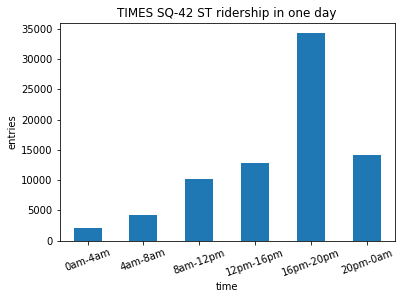

In [378]:
x_ticks = ["0am-4am", "4am-8am", "8am-12pm", "12pm-16pm", "16pm-20pm", "20pm-0am"]

ax = df_hour_plot.plot.bar(x='time', y='hourly_count',\
                                   title = "TIMES SQ-42 ST ridership in one day", legend = False, rot=0)
#ax.legend("total_ridership")
ax.set_ylabel("entries")
ax.set_xlabel("time")
ax.set_xticklabels(x_ticks, rotation=20)

## 

# Challenge 4

In [377]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'png'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

mask = ((df_cleaned["c/a"] == "A002") & 
(df_cleaned["unit"] == "R051") & 
(df_cleaned["scp"] == "02-00-00") & 
(df_cleaned["station"] == "59 ST"))
# datetime is both name of module and name of constructor of datetime object
df_cleaned

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour,daily_count,prev_date
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,00:00:00,REGULAR,6999957,2373867,2019-03-31 00:00:00,31,0,893.0,03/30/2019
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/01/2019,00:00:00,REGULAR,7000528,2374095,2019-04-01 00:00:00,1,0,571.0,03/31/2019
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/02/2019,00:00:00,REGULAR,7002087,2374579,2019-04-02 00:00:00,2,0,1559.0,04/01/2019
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/03/2019,00:00:00,REGULAR,7003680,2375133,2019-04-03 00:00:00,3,0,1593.0,04/02/2019
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/04/2019,00:00:00,REGULAR,7005332,2375557,2019-04-04 00:00:00,4,0,1652.0,04/03/2019
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/05/2019,00:00:00,REGULAR,7006970,2376068,2019-04-05 00:00:00,5,0,1638.0,04/04/2019
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/06/2019,00:00:00,REGULAR,7008540,2376546,2019-04-06 00:00:00,6,0,1570.0,04/05/2019
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/07/2019,00:00:00,REGULAR,7009464,2376791,2019-04-07 00:00:00,7,0,924.0,04/06/2019
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/08/2019,00:00:00,REGULAR,7010160,2377000,2019-04-08 00:00:00,8,0,696.0,04/07/2019
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/09/2019,00:00:00,REGULAR,7011693,2377460,2019-04-09 00:00:00,9,0,1533.0,04/08/2019


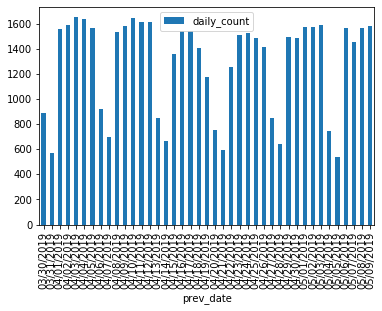

In [33]:
ax = df_cleaned[mask].plot.bar(x='prev_date', y='daily_count', rot=90)

## Group turnstiles by station

In [37]:
df_station_daily_many_weeks = df_cleaned.groupby(["station", "prev_date"], as_index=False)\
.agg({"daily_count" : "sum"}).reset_index(drop=True)

In [38]:
def add_day_of_week():
    df_station_daily_many_weeks["day_of_week"] = [(dateutil.parser.parse(date1).weekday()) for date1 in df_station_daily_many_weeks.prev_date]
add_day_of_week()

In [39]:
# df_station_daily_many_weeks.head()

## average over 5 weeks period

In [40]:
# we choose the weeks to average over our data. Taking the average will even out the fluctuation in our data caused by, i.e. national holiday on a weekday. 
five_weeks_condition = (df_station_daily_many_weeks.prev_date >= "03/30/2019") & (df_station_daily_many_weeks.prev_date <= "05/03/2019")
df_station_daily_five_weeks = df_station_daily_many_weeks[five_weeks_condition].reset_index(drop = True)

In [41]:
#df_station_daily_five_weeks.daily_count.sort_values()

In [42]:
df_station_daily_average_week = df_station_daily_five_weeks.groupby(["station", "day_of_week"], as_index=False)\
.agg({"daily_count" : "mean"}).reset_index(drop=True)

In [43]:
#df_station_daily_average_week

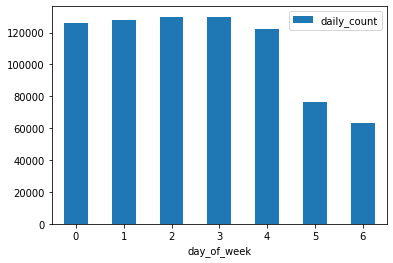

In [44]:
df_penn = df_station_daily_average_week[df_station_daily_average_week.station == "34 ST-PENN STA"] 
ax = df_penn.plot.bar(x='day_of_week', y='daily_count', rot=0)

## Which station to pick? station weekly total entry

In [45]:
df_station_weekly =  df_station_daily_average_week.groupby(["station"], as_index = False)\
.agg({"daily_count": "sum" }).sort_values(["daily_count"], ascending=False).reset_index(drop=True)

Text(0, 0.5, 'weekly ridership')

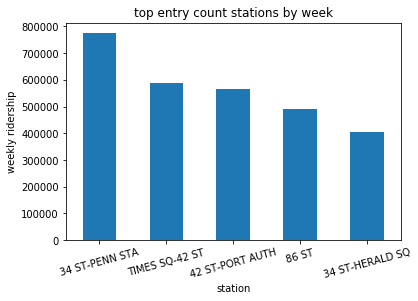

In [46]:
ax = df_station_weekly[df_station_weekly.daily_count > 400000]\
.plot.bar(x='station', y='daily_count',title = "top entry count stations by week", legend = False, rot=15)
ax.set_ylabel("weekly ridership")

## Which day of week? MTA total ridership vs day of week

[Text(0, 0, 'Mon'),
 Text(0, 0, 'Tue'),
 Text(0, 0, 'Wed'),
 Text(0, 0, 'Thu'),
 Text(0, 0, 'Fri'),
 Text(0, 0, 'Sat'),
 Text(0, 0, 'Sun')]

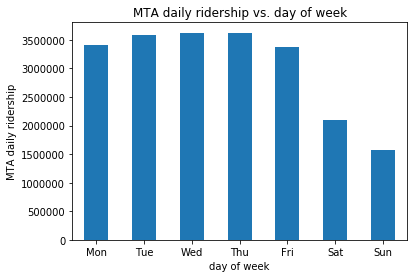

In [47]:
#to compare which day is the busiest day of week:
x_ticks = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
df_day_of_week_total = df_station_daily_average_week.groupby(["day_of_week"], as_index=False).daily_count.sum()
ax = df_day_of_week_total.plot.bar(x='day_of_week', y='daily_count',\
                                   title = "MTA daily ridership vs. day of week", legend = False, rot=0)
#ax.legend("total_ridership")
ax.set_ylabel("MTA daily ridership")
ax.set_xlabel("day of week")
ax.set_xticklabels(x_ticks, rotation=0)
#df_day_of_week_total

## What is the best time? Station entry vs hour plot